<a href="https://colab.research.google.com/github/theviderlab/computer_vision/blob/main/speed_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install supervision
!pip install inference-gpu

In [2]:
import supervision as sv
from supervision.assets import VideoAssets, download_assets
from inference.models.utils import get_roboflow_model
import urllib
import cv2
import numpy as np
import os
from collections import defaultdict, deque
from tqdm.notebook import tqdm

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [3]:
HOME = "/content"
DATA_PATH = "data"

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
os.chdir(DATA_PATH)
VIDEO_INPUT_FILENAME = download_assets(VideoAssets.VEHICLES)
VIDEO_INPUT_PATH = os.path.join(HOME, DATA_PATH, VIDEO_INPUT_FILENAME)

  0%|          | 0/35345757 [00:00<?, ?it/s]

In [4]:
print(VIDEO_INPUT_PATH)
VIDEO_OUTPUT_PATH = os.path.join(HOME, DATA_PATH, "vehicles_output.mp4")
print(VIDEO_OUTPUT_PATH)

/content/data/vehicles.mp4
/content/data/vehicles_output.mp4


In [5]:
class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray):
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [6]:
from typing import Optional, List, Tuple
from dataclasses import dataclass, field

@dataclass
class RoadConfiguration:
    width: int = 2500  # [cm]
    length: int = 25000  # [cm]
    shoulder: int = 318 # [cm]
    road: int = 690 # [cm]
    edges: List[Tuple[int, int, str]] = field(default_factory=lambda: [
        (1, 8, 'solid'), (2, 9, 'solid'), (3, 10, 'dashed'), (4, 11, 'solid'), (5, 12, 'solid'), (6, 13, 'dashed'), (7, 14, 'solid')
    ])

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, self.shoulder),  # 2
            (0, self.shoulder + self.road/2),  # 3
            (0, self.shoulder + self.road),  # 4
            (0, self.width - self.shoulder - self.road),  # 5
            (0, self.width - self.shoulder - self.road/2),  # 6
            (0, self.width - self.shoulder),  # 7
            (self.length, 0),  # 8
            (self.length, self.shoulder),  # 9
            (self.length, self.shoulder + self.road/2),  # 10
            (self.length, self.shoulder + self.road),  # 11
            (self.length, self.width - self.shoulder - self.road),  # 12
            (self.length, self.width - self.shoulder - self.road/2),  # 13
            (self.length, self.width - self.shoulder),  # 14
        ]

def draw_road(
    config: RoadConfiguration,
    background_color: sv.Color = sv.Color(177, 177, 177),
    line_color: sv.Color = sv.Color.WHITE,
    padding: int = 0,
    line_thickness: int = 4,
    scale: float = 0.1,
    line_detector: int = None
) -> np.ndarray:
    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    image = np.ones(
        (scaled_width + 2 * padding,
         scaled_length + 2 * padding, 3),
        dtype=np.uint8
    ) * np.array(background_color.as_bgr(), dtype=np.uint8)

    for start, end, type in config.edges:
        point1 = (int(config.vertices[start - 1][0] * scale) + padding,
                  int(config.vertices[start - 1][1] * scale) + padding)
        point2 = (int(config.vertices[end - 1][0] * scale) + padding,
                  int(config.vertices[end - 1][1] * scale) + padding)
        if type == 'solid':
            cv2.line(
                img=image,
                pt1=point1,
                pt2=point2,
                color=line_color.as_bgr(),
                thickness=line_thickness
            )
        elif type == 'dashed':
            cv2.line(
                img=image,
                pt1=point1,
                pt2=point2,
                color=line_color.as_bgr(),
                thickness=1
            )

    if line_detector is not None:
        point1 = (int(line_detector * scale) + padding,
                  int(0 * scale) + padding)
        point2 = (int(line_detector * scale) + padding,
                  int(config.width * scale) + padding)
        cv2.line(
            img=image,
            pt1=point1,
            pt2=point2,
            color=sv.Color.YELLOW.as_bgr(),
            thickness=line_thickness
        )

    return image


def draw_points_on_road(
    config: RoadConfiguration,
    xy: np.ndarray,
    face_color: sv.Color = sv.Color.RED,
    edge_color: sv.Color = sv.Color.BLACK,
    radius: int = 10,
    thickness: int = 2,
    padding: int = 0,
    scale: float = 0.1,
    line_detector: int = None,
    road: Optional[np.ndarray] = None
) -> np.ndarray:
    if road is None:
        road = draw_road(
            config=config,
            padding=padding,
            scale=scale,
            line_detector=line_detector
        )

    for point in xy:
        scaled_point = (
            int(point[1] * scale) + padding,
            int(point[0] * scale) + padding
        )
        cv2.circle(
            img=road,
            center=scaled_point,
            radius=radius,
            color=face_color.as_bgr(),
            thickness=-1
        )
        cv2.circle(
            img=road,
            center=scaled_point,
            radius=radius,
            color=edge_color.as_bgr(),
            thickness=thickness
        )

    return road


def draw_paths_on_road(
    config: RoadConfiguration,
    paths: List[np.ndarray],
    color: sv.Color = sv.Color.WHITE,
    thickness: int = 2,
    padding: int = 0,
    scale: float = 0.1,
    road: Optional[np.ndarray] = None
) -> np.ndarray:
    if road is None:
        road = draw_road(
            config=config,
            padding=padding,
            scale=scale
        )

    for path in paths:
        scaled_path = [
            (
                int(point[0] * scale) + padding,
                int(point[1] * scale) + padding
            )
            for point in path if point.size > 0
        ]

        if len(scaled_path) < 2:
            continue

        for i in range(len(scaled_path) - 1):
            cv2.line(
                img=road,
                pt1=scaled_path[i],
                pt2=scaled_path[i + 1],
                color=color.as_bgr(),
                thickness=thickness
            )

        return road

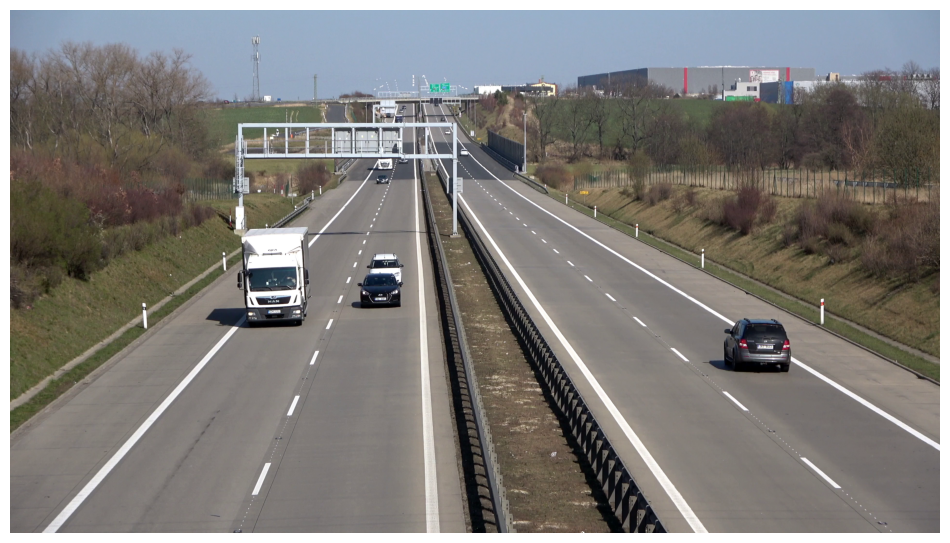

In [9]:
frame_generator = sv.get_video_frames_generator(VIDEO_INPUT_PATH)
frame = next(frame_generator)
sv.plot_image(frame)

In [7]:
video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_INPUT_PATH)
print(video_info)
model = get_roboflow_model("yolov8x-640")

byte_track = sv.ByteTrack(frame_rate=video_info.fps)

thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)
bounding_box_annotator = sv.BoxAnnotator(thickness=thickness, color_lookup=sv.ColorLookup.TRACK)
label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_thickness=thickness, text_position=sv.Position.BOTTOM_CENTER, color_lookup=sv.ColorLookup.TRACK)
trace_annotator = sv.TraceAnnotator(thickness=thickness, trace_length=video_info.fps*2, position=sv.Position.BOTTOM_CENTER, color_lookup=sv.ColorLookup.TRACK)
line_zone_annotator = sv.LineZoneAnnotator(thickness=thickness, text_thickness=thickness, text_scale=text_scale)
heat_map_annotator = sv.HeatMapAnnotator(position=sv.Position.CENTER, opacity=0.8, kernel_size=50, radius=80)

SOURCE = np.array([[1252,787],[2298,803],[5039,2159],[-550,2159]])
TARGET_WIDTH = 25
TARGET_HEIGHT = 250
TARGET = np.array(
    [
        [0,0],
        [TARGET_WIDTH - 1, 0],
        [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
        [0, TARGET_HEIGHT -1]
    ]
)
LINE_DETECTOR = 1400


polygon_zone = sv.PolygonZone(SOURCE)
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)
start, end = sv.Point(x=0, y=LINE_DETECTOR), sv.Point(x=video_info.width, y=LINE_DETECTOR)
line_zone = sv.LineZone(start=start, end=end)
line_detector_transformed = view_transformer.transform_points(points=np.array([[0,LINE_DETECTOR]])).astype(int)[0][1]

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)


In [8]:
IMAGE_MODE = False
DEBUG_MODE = False

CONFIG = RoadConfiguration()
print(CONFIG)

if IMAGE_MODE:
    total_frames = 1
else:
    if DEBUG_MODE:
        total_frames = 100  # Number of frames to process
    else:
        total_frames = video_info.total_frames

# Initialize the frame counter
frame_count = 0

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))
frame_generator = sv.get_video_frames_generator(VIDEO_INPUT_PATH)
with sv.VideoSink(VIDEO_OUTPUT_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=total_frames):
        if frame_count >= total_frames:
            break  # Stop processing if we have processed N frames

        result = model.infer(frame)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections[polygon_zone.trigger(detections)]
        detections = byte_track.update_with_detections(detections=detections)
        line_zone.trigger(detections)

        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
        points = view_transformer.transform_points(points=points).astype(int)

        road_view_frame = draw_points_on_road(
            config=CONFIG,
            scale=0.1,
            xy=points*100, # Change unit from m to cm
            line_detector=line_detector_transformed*100
        )

        labels = []
        for tracker_id, [x, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)
            if len(coordinates[tracker_id]) < video_info.fps/2:
                labels.append(f"#{tracker_id}")
            else:
                coordinates_start = coordinates[tracker_id][-1]
                coordinates_end = coordinates[tracker_id][0]
                distance = abs(coordinates_start - coordinates_end)
                time = len(coordinates[tracker_id])/video_info.fps
                speed = distance / time * 3.6
                labels.append(f"{tracker_id} {int(speed)} km/h")

        annotated_frame = frame.copy()
        annotated_frame = sv.draw_polygon(annotated_frame,polygon=SOURCE,color=sv.Color.RED)
        annotated_frame = heat_map_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
        annotated_frame = line_zone_annotator.annotate(frame=annotated_frame, line_counter=line_zone)


        # Add road view
        frame_width = annotated_frame.shape[1]
        frame_height = round(road_view_frame.shape[0]*annotated_frame.shape[1]/road_view_frame.shape[1])
        road_view_frame = cv2.resize(road_view_frame, (frame_width, frame_height))
        annotated_frame[0:frame_height, :] = road_view_frame

        if IMAGE_MODE:
            sv.plot_image(annotated_frame)
        else:
            sink.write_frame(annotated_frame)

        frame_count += 1  # Increment the frame counter

RoadConfiguration(width=2500, length=25000, shoulder=318, road=690, edges=[(1, 8, 'solid'), (2, 9, 'solid'), (3, 10, 'dashed'), (4, 11, 'solid'), (5, 12, 'solid'), (6, 13, 'dashed'), (7, 14, 'solid')])


  0%|          | 0/538 [00:00<?, ?it/s]